In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

sys.path.insert(0, 'C:/Users/Bin/Desktop/Thesis/code')
from Conf_EncDecAD_KDD99 import Conf_EncDecAD_KDD99
#from EncDecAD import EncDecAD

In [2]:
# Configuration 

data_root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"
conf = Conf_EncDecAD_KDD99(data_root)
#[sn_list, va_list, vn1_list, vn2_list, tn_list, ta_list] = conf.data_list

#p_input = conf.p_input
#p_inputs = conf.p_inputs



batch_num = conf.batch_num
hidden_num = conf.hidden_num
step_num = conf.step_num
elem_num = conf.elem_num

iteration = conf.iteration
modelpath_root = conf.modelpath_root
modelpath = conf.modelpath
decode_without_input = conf.decode_without_input


 

# Training

iter 1: 7.51197
iter 2: 7.24106
iter 3: 5.83815
iter 4: 4.83861
iter 5: 3.96047
iter 6: 3.4242
iter 7: 2.83394
iter 8: 2.23055
iter 9: 1.86834
iter 10: 1.58492
iter 11: 1.39966
iter 12: 1.18028
iter 13: 1.0044
iter 14: 0.943103
iter 15: 0.888694
iter 16: 0.81497
iter 17: 0.840342
iter 18: 0.674519
iter 19: 0.556531
iter 20: 0.557433
iter 21: 0.508053
iter 22: 0.439355
iter 23: 0.431179
iter 24: 0.459009
iter 25: 0.363388
iter 26: 0.387082
iter 27: 0.311459
iter 28: 0.302973
iter 29: 0.321011
iter 30: 0.254924
iter 31: 0.268844
iter 32: 0.245902
iter 33: 0.267388
iter 34: 0.271701
iter 35: 0.248599
iter 36: 0.198732
iter 37: 0.220623
iter 38: 0.175422
iter 39: 0.167471
iter 40: 0.178838
iter 41: 0.180768
iter 42: 0.169217
iter 43: 0.185415
iter 44: 0.159892
iter 45: 0.1608
iter 46: 0.137266
iter 47: 0.127748
iter 48: 0.123396
iter 49: 0.120896
iter 50: 0.12278
iter 51: 0.111605
iter 52: 0.118172
iter 53: 0.107634
iter 54: 0.124384
iter 55: 0.112882
iter 56: 0.102028
iter 57: 0.130443
it

'    \n    err_vec_list = []   \n    for _ in range(len(conf.vn1_list)//batch_num):\n        data =[]\n        for temp in range(batch_num):\n            ind = np.random.randint(0,len(conf.vn1_list)-1)\n            sub = conf.vn1_list[ind]\n            data.append(sub)\n        data = np.array(data)\n        (_input_, _output_) = sess.run([input_, output_], {p_input: data})\n        err_vec_list.append(abs(_input_ - _output_))\n    \n    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)\n    mu = np.mean(err_vec,axis=0)\n    sigma = np.cov(err_vec.T)\n'

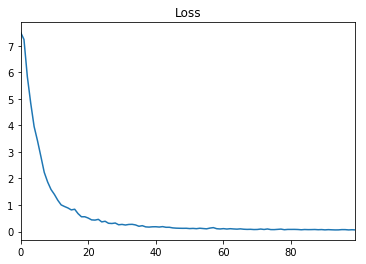

In [3]:

with tf.Session() as sess:
    
    
    
    p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num),name = "p_input")
    p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
    
    _enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
    _dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
    #inputs = conf.p_inputs
    inputs = p_inputs #...
    
    reverse = True
    decode_without_input = False
    is_training = True
    with tf.variable_scope('encoder',reuse = tf.AUTO_REUSE):
        (z_codes, enc_state) = tf.contrib.rnn.static_rnn(_enc_cell, inputs, dtype=tf.float32)

    with tf.variable_scope('decoder',reuse =tf.AUTO_REUSE) as vs:

        dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,elem_num], dtype=tf.float32),name="dec_weight_")

        dec_bias_ = tf.Variable(tf.constant(0.1,shape=[elem_num],dtype=tf.float32),name="dec_bias_")


        dec_state = enc_state
        dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
        dec_outputs = []

        for step in range(len(inputs)):
            if step > 0:
                vs.reuse_variables()
            (dec_input_, dec_state) =_dec_cell(dec_input_, dec_state)
            dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
            dec_outputs.append(dec_input_)
    
        if reverse:
            dec_outputs = dec_outputs[::-1]

        output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2],name="output_")

            
            
    
    input_= tf.transpose(tf.stack(inputs), [1, 0, 2],name="input_")
#    output_ = tf.transpose(output_, [0,1,2])
    loss_ = tf.reduce_mean(tf.square(input_ - output_),name="loss_")

   
    train_ = tf.train.AdamOptimizer().minimize(loss_)
    #train_ = tf.train.GradientDescentOptimizer(0.01).minimize(loss_)
    
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())


    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(conf.sn_list)-1)
            sub = conf.sn_list[ind]
            data.append(sub)
        data = np.array(data)

        (loss_val, _) = sess.run([loss_, train_], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss")
    


    save_path = saver.save(sess, modelpath)
    print("Model saved in file: %s" % save_path) 


"""    
    err_vec_list = []   
    for _ in range(len(conf.vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(conf.vn1_list)-1)
            sub = conf.vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (_input_, _output_) = sess.run([input_, output_], {p_input: data})
        err_vec_list.append(abs(_input_ - _output_))
    
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
"""

In [ ]:
ae = EncDecAD(hidden_num, p_inputs, is_training = True, decode_without_input=False)

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(conf.sn_list)-1)
            sub = conf.sn_list[ind]
            data.append(sub)
        data = np.array(data)
        
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss")

    save_path = saver.save(sess, modelpath)
    print("Model saved in file: %s" % save_path)

# Calculate parameters using Vn1 dataset 

In [4]:
from Parameter_helper import Parameter_Helper

para = Parameter_Helper(conf)

mu, sigma = para.mu_and_sigma()

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.
[ 0.19463608  0.11765845  0.13154957  0.18010619  0.11181988  0.05767112
  0.12715456  0.06118212  0.24614303  0.07082351  0.1498466   0.21913306
  0.09148553  0.08496854  0.2224772   0.08920401  0.10600094  0.27662054
  0.22896647  0.06222694  0.07404834  0.21031396  0.10301597  0.28576559
  0.48060146  0.40352878  0.51187122  0.1618385   0.1194734   0.16127291
  0.1798491   0.07099917  0.05087043  0.07606138  0.18938069  0.11362384
  0.13247427  0.15461209  0.1103431   0.04980225  0.10199855  0.05496701
  0.2119652   0.07680407  0.14027238  0.20153554  0.07812548  0.06630364
  0.18447158  0.0939533   0.08540108  0.27285659  0.2393146   0.0620846
  0.08067043  0.18169461  0.09672682  0.27894354  0.47332352  0.40689787
  0.50511062  0.13631585  0.11195876  0.12283494  0.15848689  0.05407965
  0.03996972  0.06563514  0.17

# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [ ]:
threshold = para.get_threshold(mu,sigma)

# test

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, modelpath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [ ]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

In [ ]:
print(tp,fp,tn,fn,P,R)

In [ ]:
tp/fp